<a href="https://colab.research.google.com/github/nigamreetesh84/predict-fraudulent-credit-card-transactions/blob/main/Credit_card_fraud_detection_Starter_code_reetesh_nigam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sklearn
import xgboost as xgb

from sklearn import preprocessing
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, GridSearchCV,
    RandomizedSearchCV, learning_curve, cross_val_score
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, roc_curve,
    precision_recall_curve, confusion_matrix, classification_report,
    ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.calibration import calibration_curve

from imblearn import over_sampling
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier

try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("="*70)
print("ENVIRONMENT INFORMATION")
print("="*70)
print(f"Python: {sys.version.split()[0]}")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Scikit-learn: {sklearn.__version__}")
print(f"XGBoost: {xgb.__version__}")
print(f"SHAP: {SHAP_AVAILABLE}")
print("="*70)

ENVIRONMENT INFORMATION
Python: 3.12.12
NumPy: 2.0.2
Pandas: 2.2.2
Scikit-learn: 1.6.1
XGBoost: 3.1.2
SHAP: True


## Exploratory data analysis

In [17]:
# ============================================================================
# DATASET DIAGNOSTIC & REPAIR TOOL
# ============================================================================


try:
    df = pd.read_csv('/content/sample_data/creditcard.csv')
    print(f"✓ Dataset loaded: {df.shape}")
except Exception as e:
    print(f"❌ ERROR loading dataset: {e}")

df.head()

✓ Dataset loaded: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
#observe the different feature type present in the data

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9965 entries, 0 to 9964
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    9965 non-null   int64  
 1   V1      9965 non-null   float64
 2   V2      9965 non-null   float64
 3   V3      9964 non-null   float64
 4   V4      9964 non-null   float64
 5   V5      9964 non-null   float64
 6   V6      9964 non-null   float64
 7   V7      9964 non-null   float64
 8   V8      9964 non-null   float64
 9   V9      9964 non-null   float64
 10  V10     9964 non-null   float64
 11  V11     9964 non-null   float64
 12  V12     9964 non-null   float64
 13  V13     9964 non-null   float64
 14  V14     9964 non-null   float64
 15  V15     9964 non-null   float64
 16  V16     9964 non-null   float64
 17  V17     9964 non-null   float64
 18  V18     9964 non-null   float64
 19  V19     9964 non-null   float64
 20  V20     9964 non-null   float64
 21  V21     9964 non-null   float64
 22  

In [6]:


# Here we will observe the distribution of our classes
class_counts = df['Class'].value_counts()
print("\nClass Distribution:")
print(class_counts)


Class Distribution:
Class
0.0    9926
1.0      38
Name: count, dtype: int64


In [7]:
classes = df['Class'].value_counts()
normal_share = classes[0]/df['Class'].count()*100
fraud_share = classes[1]/df['Class'].count()*100
print(f"\nNormal transactions: {normal_share:.2f}%")
print(f"Fraudulent transactions: {fraud_share:.2f}%")


Normal transactions: 99.62%
Fraudulent transactions: 0.38%


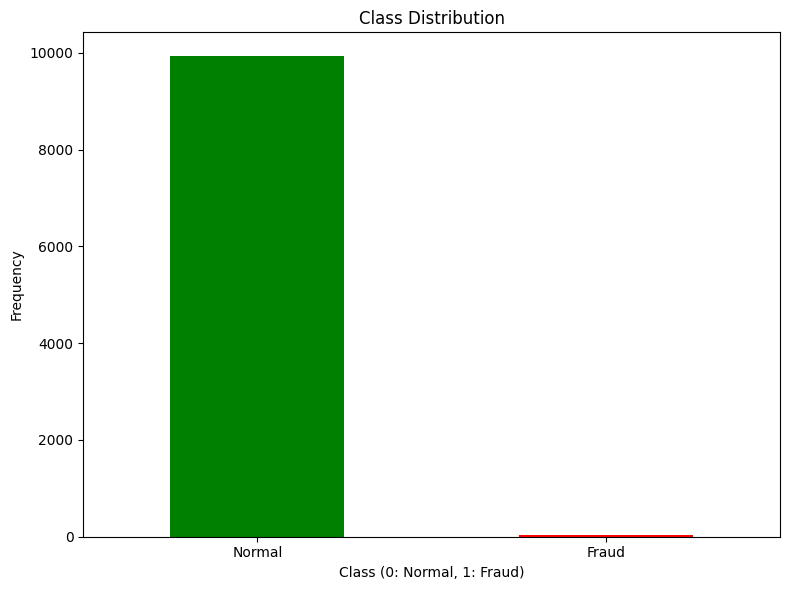

In [8]:
# Create a bar plot for the number and percentage of fraudulent vs non-fraudulent transactions
fig, ax = plt.subplots(figsize=(8, 6))
classes.plot(kind='bar', ax=ax, color=['green', 'red'])
ax.set_title('Class Distribution')
ax.set_xlabel('Class (0: Normal, 1: Fraud)')
ax.set_ylabel('Frequency')
ax.set_xticklabels(['Normal', 'Fraud'], rotation=0)
plt.tight_layout()
plt.show()


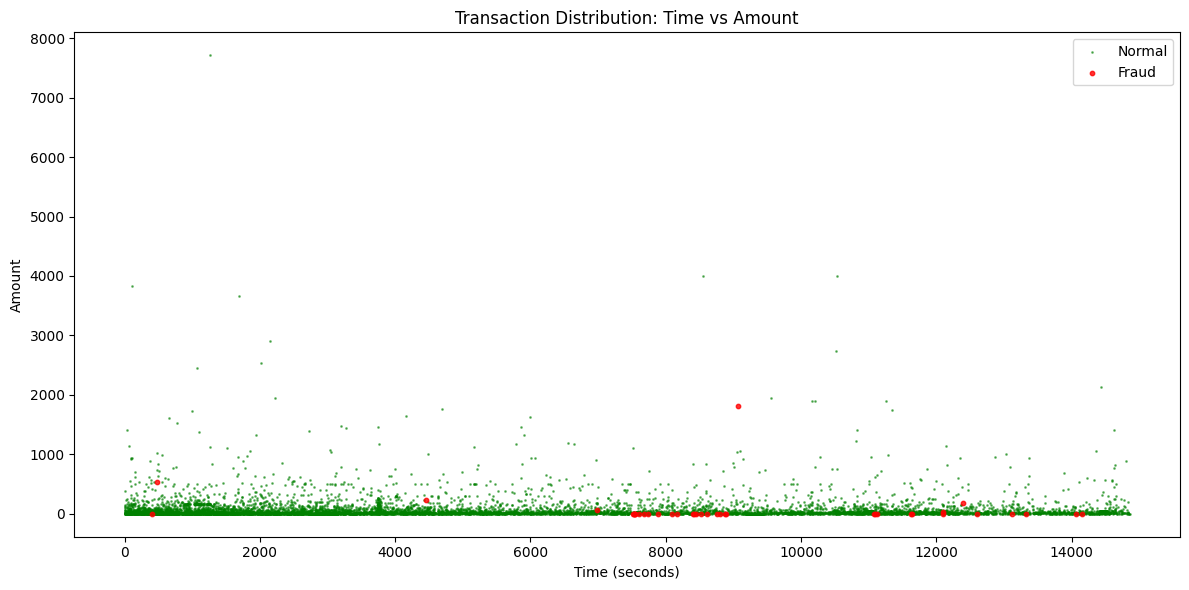

In [9]:
# Create a scatter plot to observe the distribution of classes with time
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(df[df['Class']==0]['Time'], df[df['Class']==0]['Amount'],
           alpha=0.5, s=1, label='Normal', c='green')
ax.scatter(df[df['Class']==1]['Time'], df[df['Class']==1]['Amount'],
           alpha=0.8, s=10, label='Fraud', c='red')
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Amount')
ax.set_title('Transaction Distribution: Time vs Amount')
ax.legend()
plt.tight_layout()
plt.show()

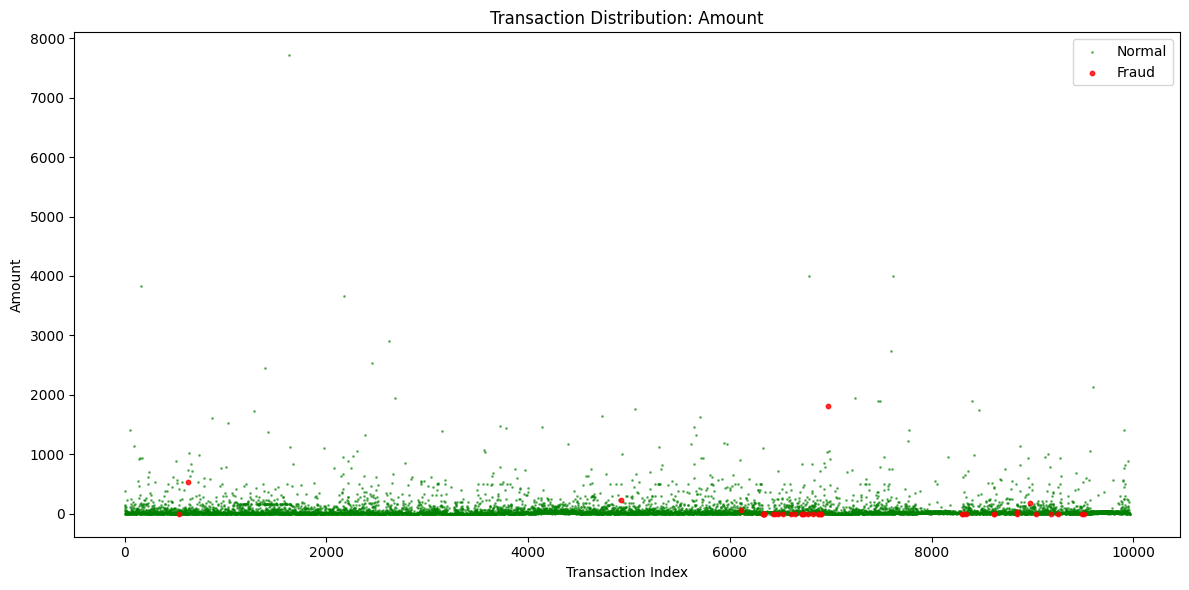

In [10]:
# Create a scatter plot to observe the distribution of classes with Amount
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(df[df['Class']==0].index, df[df['Class']==0]['Amount'],
           alpha=0.5, s=1, label='Normal', c='green')
ax.scatter(df[df['Class']==1].index, df[df['Class']==1]['Amount'],
           alpha=0.8, s=10, label='Fraud', c='red')
ax.set_xlabel('Transaction Index')
ax.set_ylabel('Amount')
ax.set_title('Transaction Distribution: Amount')
ax.legend()
plt.tight_layout()
plt.show()

In [18]:
# Drop unnecessary columns
print("\nDropping 'Time' column...")
df = df.drop(['Time'], axis=1)
print(f"✓ New shape: {df.shape}")


Dropping 'Time' column...
✓ New shape: (284807, 30)


In [19]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [20]:
X = df.drop(['Class'], axis=1)
y = df['Class']
print(f"✓ Features: {X.shape}")
print(f"✓ Target: {y.shape}")

✓ Features: (284807, 29)
✓ Target: (284807,)


In [21]:
print("NaNs in y:", y.isna().sum())
print(y.value_counts(dropna=False))

NaNs in y: 0
Class
0    284315
1       492
Name: count, dtype: int64


In [15]:
mask = y.notna()
X = X.loc[mask]
y = y.loc[mask]

In [22]:
y = y.astype(int)

In [23]:



# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.7, stratify=y, random_state=RANDOM_STATE
)

print(f"\n✓ Train: {X_train.shape[0]} samples ({y_train.sum()} frauds)")
print(f"✓ Test: {X_test.shape[0]} samples ({y_test.sum()} frauds)")




✓ Train: 85442 samples (148 frauds)
✓ Test: 199365 samples (344 frauds)


In [24]:
# Preserve X_test & y_test to evaluate on the test data once you build the model
print(f"\nTotal fraud cases: {np.sum(y)}")
print(f"Train fraud cases: {np.sum(y_train)}")
print(f"Test fraud cases: {np.sum(y_test)}")

print(f"\n✓ Train set: {X_train.shape[0]} samples")
print(f"✓ Test set: {X_test.shape[0]} samples")


Total fraud cases: 492
Train fraud cases: 148
Test fraud cases: 344

✓ Train set: 85442 samples
✓ Test set: 199365 samples


In [25]:
print(np.sum(y))
print(np.sum(y_train))
print(np.sum(y_test))

492
148
344


### Plotting the distribution of a variable

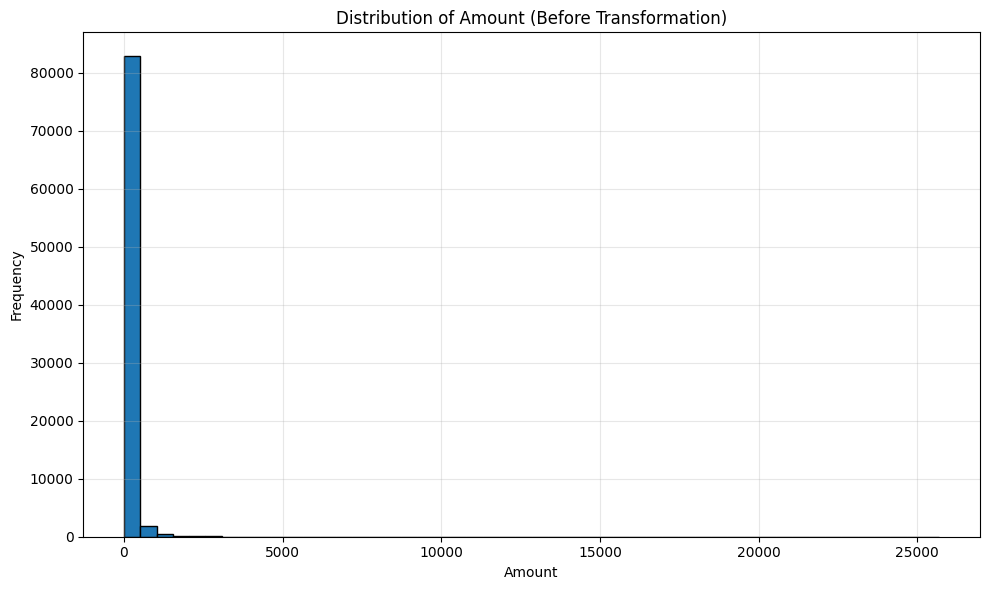

In [26]:
# Plot the histogram of a variable from the dataset to see the skewness
plt.figure(figsize=(10, 6))
plt.hist(X_train['Amount'], bins=50, edgecolor='black')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Amount (Before Transformation)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



### If there is skewness present in the distribution use:
- <b>Power Transformer</b> package present in the <b>preprocessing library provided by sklearn</b> to make distribution more gaussian

In [27]:
# Apply: preprocessing.PowerTransformer(copy=False) to fit & transform the train & test data
pt = preprocessing.PowerTransformer(method='yeo-johnson', copy=False)

# Transform training data
X_train_transformed = pt.fit_transform(X_train)
X_train = pd.DataFrame(X_train_transformed, columns=X_train.columns, index=X_train.index)

# Transform test data
X_test_transformed = pt.transform(X_test)
X_test = pd.DataFrame(X_test_transformed, columns=X_test.columns, index=X_test.index)

print("✓ Power transformation applied")

✓ Power transformation applied


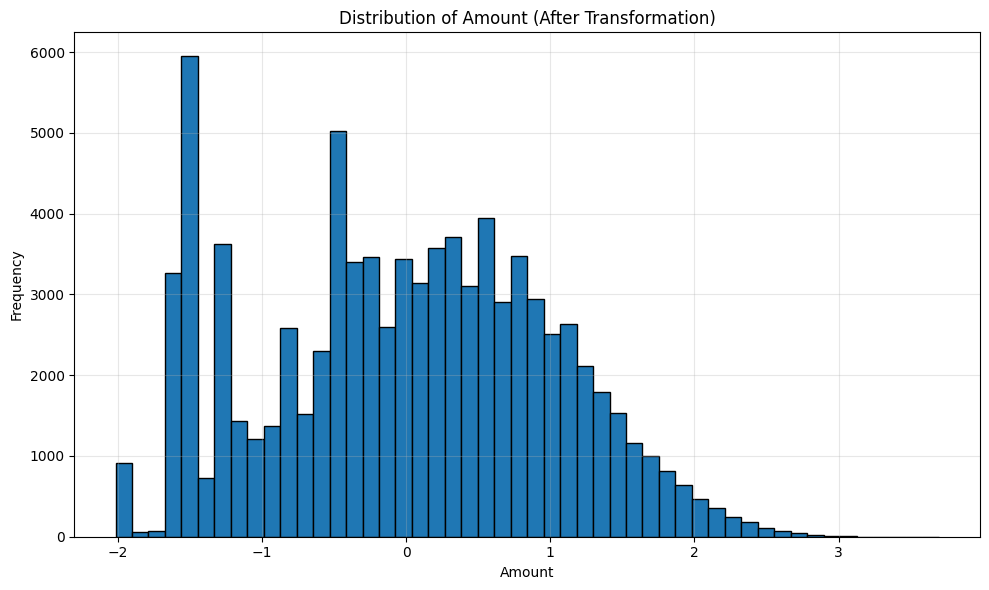

In [28]:
# Plot the histogram of a variable from the dataset again to see the result
plt.figure(figsize=(10, 6))
plt.hist(X_train['Amount'], bins=50, edgecolor='black')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Amount (After Transformation)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [29]:
# ============================================================================
# SECTION 5: MODEL BUILDING - ULTRA-OPTIMIZED
# ============================================================================

print("\n" + "="*70)
print("PHASE 1: MODELS ON IMBALANCED DATA (ULTRA-OPTIMIZED)")
print("="*70)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
scoring = 'roc_auc'
N_JOBS = 8  # safer than -1 on Windows

models_imbalanced = {
    'Logistic Regression': {
        'model': LogisticRegression(
            solver='liblinear',
            class_weight='balanced',
            random_state=RANDOM_STATE,
            max_iter=1000
        ),
        'params': {'C': [0.1, 1, 10], 'penalty': ['l2']}
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {'n_neighbors': [5], 'weights': ['distance'], 'metric': ['euclidean']}
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(
            class_weight='balanced',
            random_state=RANDOM_STATE
        ),
        'params': {'max_depth': [5, 7, 10], 'min_samples_split': [2], 'criterion': ['gini']}
    },
    'Random Forest': {
        'model': RandomForestClassifier(
            n_estimators=50,
            class_weight='balanced',
            random_state=RANDOM_STATE,
            n_jobs=N_JOBS
        ),
        'params': {'max_depth': [6, 8], 'max_features': ['sqrt']}
    },
    'XGBoost': {
        'model': XGBClassifier(
            eval_metric='auc',
            scale_pos_weight=(len(y_train)-sum(y_train))/sum(y_train),
            random_state=RANDOM_STATE,
            n_jobs=N_JOBS,
            tree_method="hist"
        ),
        'params': {'max_depth': [3, 5], 'learning_rate': [0.1], 'n_estimators': [100]}
    }
}

print("\nTraining models ...\n")

best_models_imbalanced = {}
imbalanced_results = []

for name, config in models_imbalanced.items():
    print(f"Training {name}...")

    if name in ['Decision Tree', 'Random Forest', 'XGBoost']:
        search = RandomizedSearchCV(
            config['model'],
            config['params'],
            n_iter=4,
            scoring=scoring,
            cv=cv,
            n_jobs=N_JOBS,
            random_state=RANDOM_STATE,
            verbose=0
        )
    else:
        search = GridSearchCV(
            config['model'],
            config['params'],
            scoring=scoring,
            cv=cv,
            n_jobs=N_JOBS,
            verbose=0
        )

    search.fit(X_train, y_train)
    best_models_imbalanced[name] = search.best_estimator_

    imbalanced_results.append({
        'Model': name,
        'Best_Params': str(search.best_params_),
        'CV_ROC_AUC': search.best_score_,
        'CV_Time_Sec': search.refit_time_
    })

    print(f"  ✓ CV ROC-AUC: {search.best_score_:.4f}, Time: {search.refit_time_:.2f}s\n")

    import gc
    gc.collect()



PHASE 1: MODELS ON IMBALANCED DATA (ULTRA-OPTIMIZED)

Training models ...

Training Logistic Regression...
  ✓ CV ROC-AUC: 0.9767, Time: 1.42s

Training KNN...
  ✓ CV ROC-AUC: 0.9255, Time: 0.02s

Training Decision Tree...
  ✓ CV ROC-AUC: 0.8987, Time: 5.16s

Training Random Forest...
  ✓ CV ROC-AUC: 0.9840, Time: 17.99s

Training XGBoost...
  ✓ CV ROC-AUC: 0.9824, Time: 1.44s



In [30]:

# ============================================================================
# SECTION 6: EVALUATION FUNCTION
# ============================================================================

def evaluate_model_comprehensive(model, X_test, y_test, model_name,
                                  sampling_method='None', threshold=0.5):
    """Comprehensive model evaluation"""
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba >= threshold).astype(int)

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    total_frauds = tp + fn
    total_normal = tn + fp

    return {
        'Model': model_name,
        'Sampling': sampling_method,
        'Threshold': threshold,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1_Score': f1_score(y_test, y_pred, zero_division=0),
        'ROC_AUC': roc_auc_score(y_test, y_pred_proba),
        'PR_AUC': average_precision_score(y_test, y_pred_proba),
        'True_Negatives': tn,
        'False_Positives': fp,
        'False_Negatives': fn,
        'True_Positives': tp,
        'Frauds_Detected': tp,
        'Total_Frauds': total_frauds,
        'Fraud_Detection_Rate': tp / total_frauds if total_frauds > 0 else 0,
        'False_Alarm_Rate': fp / total_normal if total_normal > 0 else 0,
        'Total_Cost': (fp * 5) + (fn * 100),
        'Cost_Per_Transaction': ((fp * 5) + (fn * 100)) / len(y_test)
    }

# Evaluate imbalanced models
print("\n" + "="*70)
print("IMBALANCED DATA - TEST EVALUATION")
print("="*70)

test_results_imbalanced = []
for name, model in best_models_imbalanced.items():
    results = evaluate_model_comprehensive(model, X_test, y_test, name, 'Imbalanced')
    test_results_imbalanced.append(results)

test_df_imbalanced = pd.DataFrame(test_results_imbalanced)
key_metrics = ['Model', 'Recall', 'Precision', 'F1_Score', 'ROC_AUC',
               'PR_AUC', 'Frauds_Detected', 'Total_Cost']
print("\n" + test_df_imbalanced[key_metrics].to_string(index=False))


IMBALANCED DATA - TEST EVALUATION

              Model   Recall  Precision  F1_Score  ROC_AUC   PR_AUC  Frauds_Detected  Total_Cost
Logistic Regression 0.912791   0.055146  0.104008 0.972275 0.730799              314       29900
                KNN 0.752907   0.915194  0.826156 0.902465 0.782896              259        8620
      Decision Tree 0.779070   0.076375  0.139112 0.886707 0.278512              268       23805
      Random Forest 0.755814   0.852459  0.801233 0.976334 0.726316              260        8625
            XGBoost 0.819767   0.470785  0.598091 0.974822 0.730185              282        7785



PHASE 2: MODELS ON BALANCED DATA 

Visualizing sampling methods...


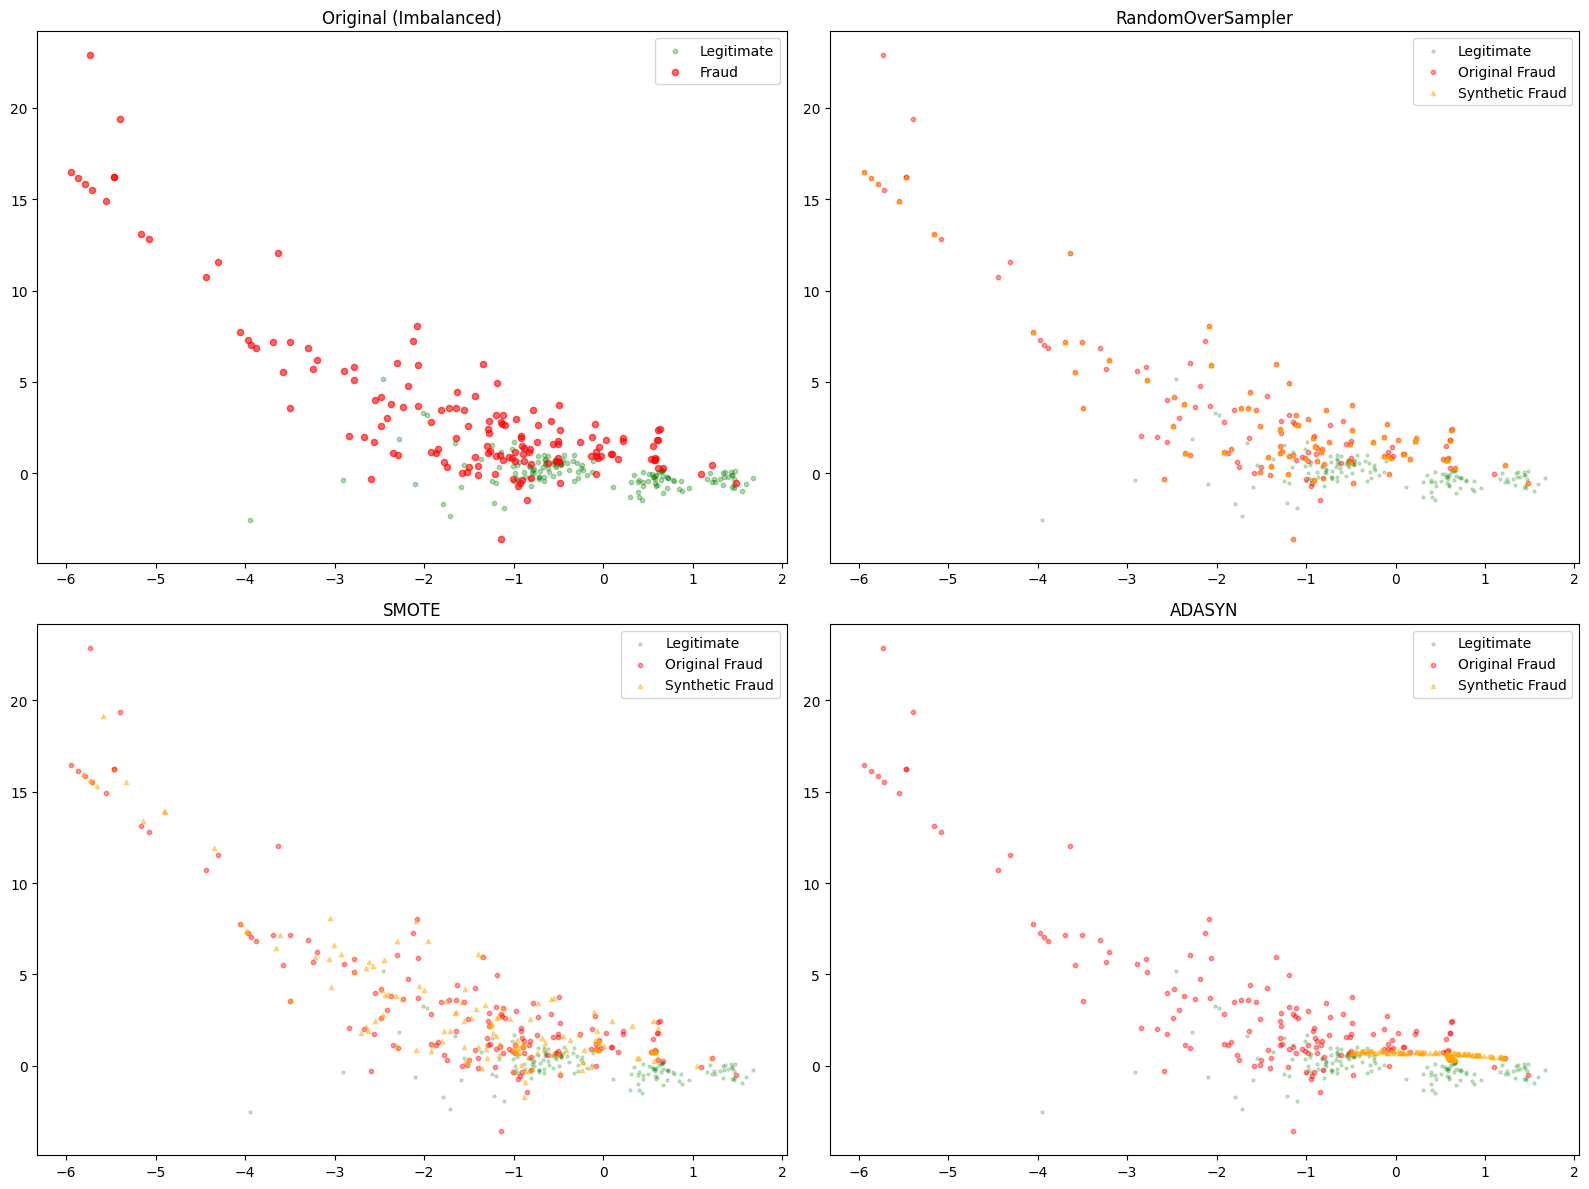

✓ Sampling visualization saved

Training balanced models (ETA: 8-12 minutes)...


SAMPLING: RandomOverSampler
Training Logistic Regression...
  ✓ CV ROC-AUC: 0.9768

Training KNN...
  ✓ Trained (no CV for KNN)

Training Decision Tree...
  ✓ CV ROC-AUC: 0.9098

Training Random Forest...
  ✓ CV ROC-AUC: 0.9840

Training XGBoost...
  ✓ CV ROC-AUC: 0.9608


SAMPLING: SMOTE
Training Logistic Regression...
  ✓ CV ROC-AUC: 0.9768

Training KNN...
  ✓ Trained (no CV for KNN)

Training Decision Tree...
  ✓ CV ROC-AUC: 0.9005

Training Random Forest...
  ✓ CV ROC-AUC: 0.9877

Training XGBoost...
  ✓ CV ROC-AUC: 0.9635


SAMPLING: ADASYN
Training Logistic Regression...
  ✓ CV ROC-AUC: 0.9763

Training KNN...
  ✓ Trained (no CV for KNN)

Training Decision Tree...
  ✓ CV ROC-AUC: 0.9283

Training Random Forest...
  ✓ CV ROC-AUC: 0.9878

Training XGBoost...
  ✓ CV ROC-AUC: 0.9656


BALANCED DATA - CV RESULTS
         Sampling               Model  CV_ROC_AUC                                           

In [31]:
# ============================================================================
# SECTION 7: CLASS BALANCING WITH SAMPLING
# ============================================================================

print("\n" + "="*70)
print("PHASE 2: MODELS ON BALANCED DATA ")
print("="*70)

samplers = {
    'RandomOverSampler': over_sampling.RandomOverSampler(random_state=RANDOM_STATE),
    'SMOTE': over_sampling.SMOTE(random_state=RANDOM_STATE),
    'ADASYN': over_sampling.ADASYN(random_state=RANDOM_STATE)
}

print("\nVisualizing sampling methods...")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

X_train_1 = X_train[y_train==1].values
X_train_0 = X_train[y_train==0].values
np.random.seed(RANDOM_STATE)
np.random.shuffle(X_train_0)

vis_sample_size = min(500, len(X_train_1))

axes[0,0].scatter(X_train_0[:vis_sample_size, 0], X_train_0[:vis_sample_size, 1],
                  alpha=0.3, s=10, label='Legitimate', c='green')
axes[0,0].scatter(X_train_1[:vis_sample_size, 0], X_train_1[:vis_sample_size, 1],
                  alpha=0.6, s=20, label='Fraud', c='red')
axes[0,0].set_title('Original (Imbalanced)')
axes[0,0].legend()

for idx, (sampler_name, sampler) in enumerate(samplers.items(), 1):
    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    X_synthetic = X_resampled[len(X_train):].values

    synthetic_sample = min(vis_sample_size, len(X_synthetic))  # OPTIMIZED

    axes.flatten()[idx].scatter(X_train_0[:vis_sample_size, 0],
                                X_train_0[:vis_sample_size, 1],
                                alpha=0.2, s=5, label='Legitimate', c='green')
    axes.flatten()[idx].scatter(X_train_1[:vis_sample_size, 0],
                                X_train_1[:vis_sample_size, 1],
                                alpha=0.4, s=10, label='Original Fraud', c='red')
    axes.flatten()[idx].scatter(X_synthetic[:synthetic_sample, 0],
                                X_synthetic[:synthetic_sample, 1],
                                alpha=0.4, s=10, label='Synthetic Fraud',
                                c='orange', marker='^')
    axes.flatten()[idx].set_title(f'{sampler_name}')
    axes.flatten()[idx].legend()

plt.tight_layout()
plt.savefig('sampling_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Sampling visualization saved")



N_JOBS = 8

best_models_balanced = {}
balanced_results = []

for sampler_name, sampler in samplers.items():
    print(f"\n{'='*70}")
    print(f"SAMPLING: {sampler_name}")
    print(f"{'='*70}")

    for model_name, config in models_imbalanced.items():
        print(f"Training {model_name}...")

        pipeline = ImbPipeline([
            ('sampler', sampler),
            ('classifier', config['model'])
        ])

        params_pipeline = {f'classifier__{k}': v for k, v in config['params'].items()}

        # KNN optimization (safe)
        if model_name == 'KNN':
            pipeline.fit(X_train, y_train)
            best_models_balanced[f"{sampler_name}_{model_name}"] = pipeline
            balanced_results.append({
                'Sampling': sampler_name,
                'Model': model_name,
                'CV_ROC_AUC': np.nan,
                'Best_Params': 'Default'
            })
            print("  ✓ Trained (no CV for KNN)\n")
            continue

        if model_name in ['Decision Tree', 'Random Forest', 'XGBoost']:
            search = RandomizedSearchCV(
                pipeline,
                params_pipeline,
                n_iter=6,
                scoring=scoring,
                cv=cv,
                n_jobs=N_JOBS,
                random_state=RANDOM_STATE,
                verbose=0
            )
        else:
            search = GridSearchCV(
                pipeline,
                params_pipeline,
                scoring=scoring,
                cv=cv,
                n_jobs=N_JOBS,
                verbose=0
            )

        search.fit(X_train, y_train)

        key = f"{sampler_name}_{model_name}"
        best_models_balanced[key] = search.best_estimator_

        balanced_results.append({
            'Sampling': sampler_name,
            'Model': model_name,
            'CV_ROC_AUC': search.best_score_,
            'Best_Params': str(search.best_params_)
        })

        print(f"  ✓ CV ROC-AUC: {search.best_score_:.4f}\n")

        import gc
        gc.collect()


balanced_cv_df = pd.DataFrame(balanced_results)
print("\n" + "="*70)
print("BALANCED DATA - CV RESULTS")
print("="*70)
print(balanced_cv_df.to_string(index=False))

# Evaluate balanced models
print("\n" + "="*70)
print("BALANCED DATA - TEST EVALUATION")
print("="*70)

test_results_balanced = []
for key, model in best_models_balanced.items():
    sampler_name, model_name = key.split('_', 1)
    results = evaluate_model_comprehensive(model, X_test, y_test,
                                          model_name, sampler_name)
    test_results_balanced.append(results)

test_df_balanced = pd.DataFrame(test_results_balanced)
print("\n" + test_df_balanced[key_metrics].to_string(index=False))

In [32]:
# ============================================================================
# SECTION 8: COMPREHENSIVE COMPARISON
# ============================================================================

print("\n" + "="*70)
print("COMPREHENSIVE COMPARISON (ALL 24 CONFIGURATIONS)")
print("="*70)

all_results = pd.concat([test_df_imbalanced, test_df_balanced], ignore_index=True)
all_results_sorted = all_results.sort_values('F1_Score', ascending=False)

print("\nTop 10 by F1-Score:")
print(all_results_sorted[key_metrics].head(10).to_string(index=False))

print("\nTop 10 by Recall:")
print(all_results.sort_values('Recall', ascending=False)[key_metrics].head(10).to_string(index=False))

print("\nTop 10 by Cost (Lower=Better):")
print(all_results.sort_values('Total_Cost')[key_metrics].head(10).to_string(index=False))

all_results.to_csv('complete_model_comparison.csv', index=False)
print("\n✓ Complete results saved: complete_model_comparison.csv")

# Select best model
best_config = all_results_sorted.iloc[0]
best_model_name = f"{best_config['Sampling']}_{best_config['Model']}"
best_model = (best_models_balanced[best_model_name] if best_config['Sampling'] != 'Imbalanced'
              else best_models_imbalanced[best_config['Model']])

print("\n" + "="*70)
print("BEST MODEL SELECTED")
print("="*70)
print(f"Model: {best_config['Model']}")
print(f"Sampling: {best_config['Sampling']}")
print(f"F1-Score: {best_config['F1_Score']:.4f}")
print(f"Recall: {best_config['Recall']:.4f}")
print(f"Precision: {best_config['Precision']:.4f}")
print(f"ROC-AUC: {best_config['ROC_AUC']:.4f}")
print(f"Frauds Detected: {int(best_config['Frauds_Detected'])}/{int(best_config['Total_Frauds'])}")
print(f"Total Cost: ${best_config['Total_Cost']:,.2f}")


COMPREHENSIVE COMPARISON (ALL 24 CONFIGURATIONS)

Top 10 by F1-Score:
        Model   Recall  Precision  F1_Score  ROC_AUC   PR_AUC  Frauds_Detected  Total_Cost
          KNN 0.752907   0.915194  0.826156 0.902465 0.782896              259        8620
Random Forest 0.755814   0.852459  0.801233 0.976334 0.726316              260        8625
Random Forest 0.773256   0.751412  0.762178 0.975843 0.695133              266        8240
      XGBoost 0.819767   0.470785  0.598091 0.974822 0.730185              282        7785
          KNN 0.811047   0.429231  0.561368 0.909323 0.554653              279        8355
          KNN 0.811047   0.429231  0.561368 0.909323 0.554653              279        8355
          KNN 0.811047   0.429231  0.561368 0.909323 0.554653              279        8355
Random Forest 0.808140   0.236797  0.366271 0.974460 0.650844              278       11080
Random Forest 0.813953   0.184453  0.300752 0.972343 0.700034              280       12590
Decision Tree 0.779


Confusion Matrix:
[[198997     24]
 [    85    259]]


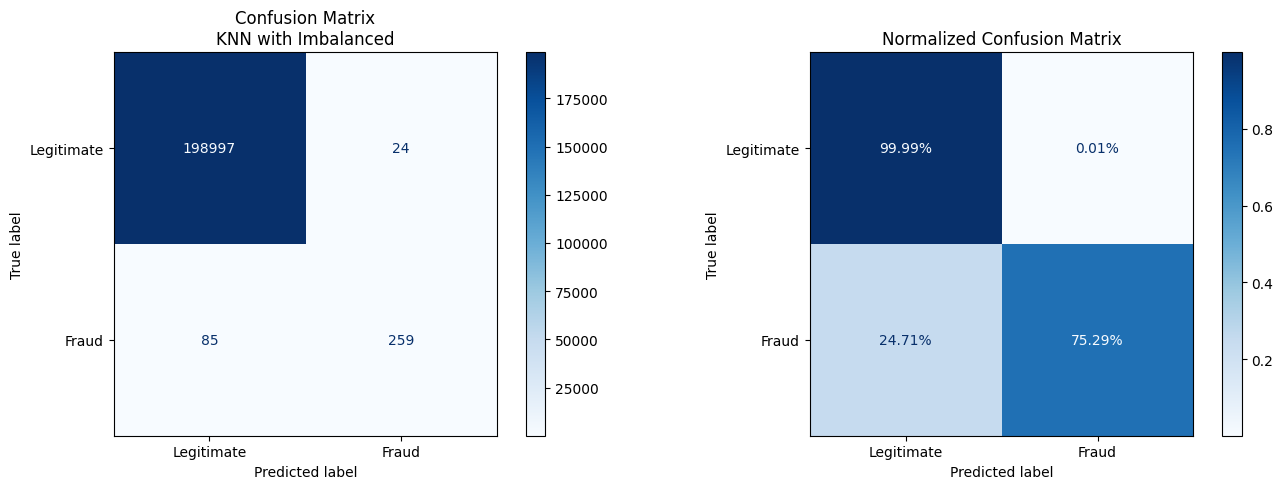


Classification Report:
              precision    recall  f1-score   support

  Legitimate     0.9996    0.9999    0.9997    199021
       Fraud     0.9152    0.7529    0.8262       344

    accuracy                         0.9995    199365
   macro avg     0.9574    0.8764    0.9129    199365
weighted avg     0.9994    0.9995    0.9994    199365



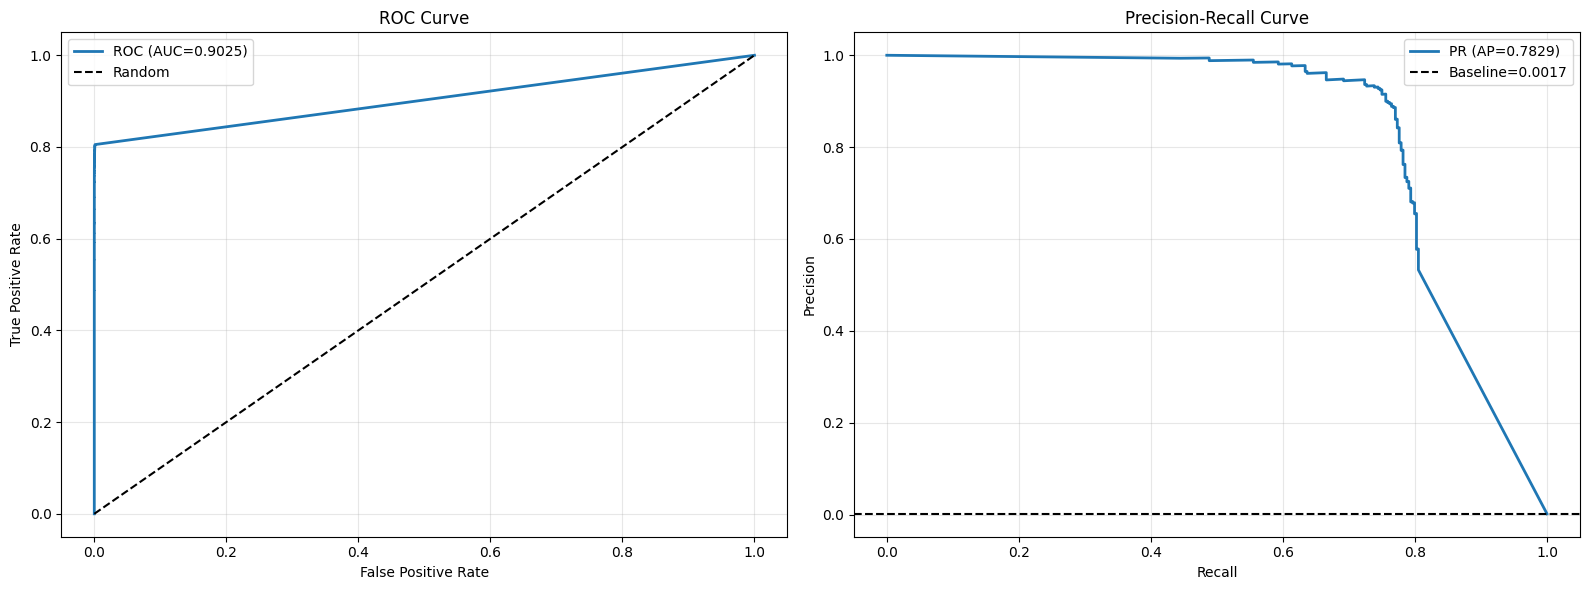


✓ ROC-AUC: 0.9025
✓ PR-AUC: 0.7829

THRESHOLD OPTIMIZATION

Optimal Threshold: 0.1700
TPR at optimal: 0.8052
FPR at optimal: 0.0010

Threshold Analysis:
 Threshold   Recall  Precision  F1_Score  Frauds_Detected  Total_Cost
  0.100000 0.805233   0.536822  0.644186              277        7895
  0.200000 0.790698   0.715789  0.751381              272        7740
  0.300000 0.773256   0.855305  0.812214              266        8025
  0.400000 0.767442   0.888889  0.823713              264        8165
  0.500000 0.752907   0.915194  0.826156              259        8620
  0.169951 0.805233   0.578288  0.673147              277        7710
  0.600000 0.720930   0.946565  0.818482              248        9670
  0.700000 0.665698   0.950207  0.782906              229       11560
  0.800000 0.616279   0.976959  0.755793              212       13225
  0.900000 0.465116   0.993789  0.633663              160       18405


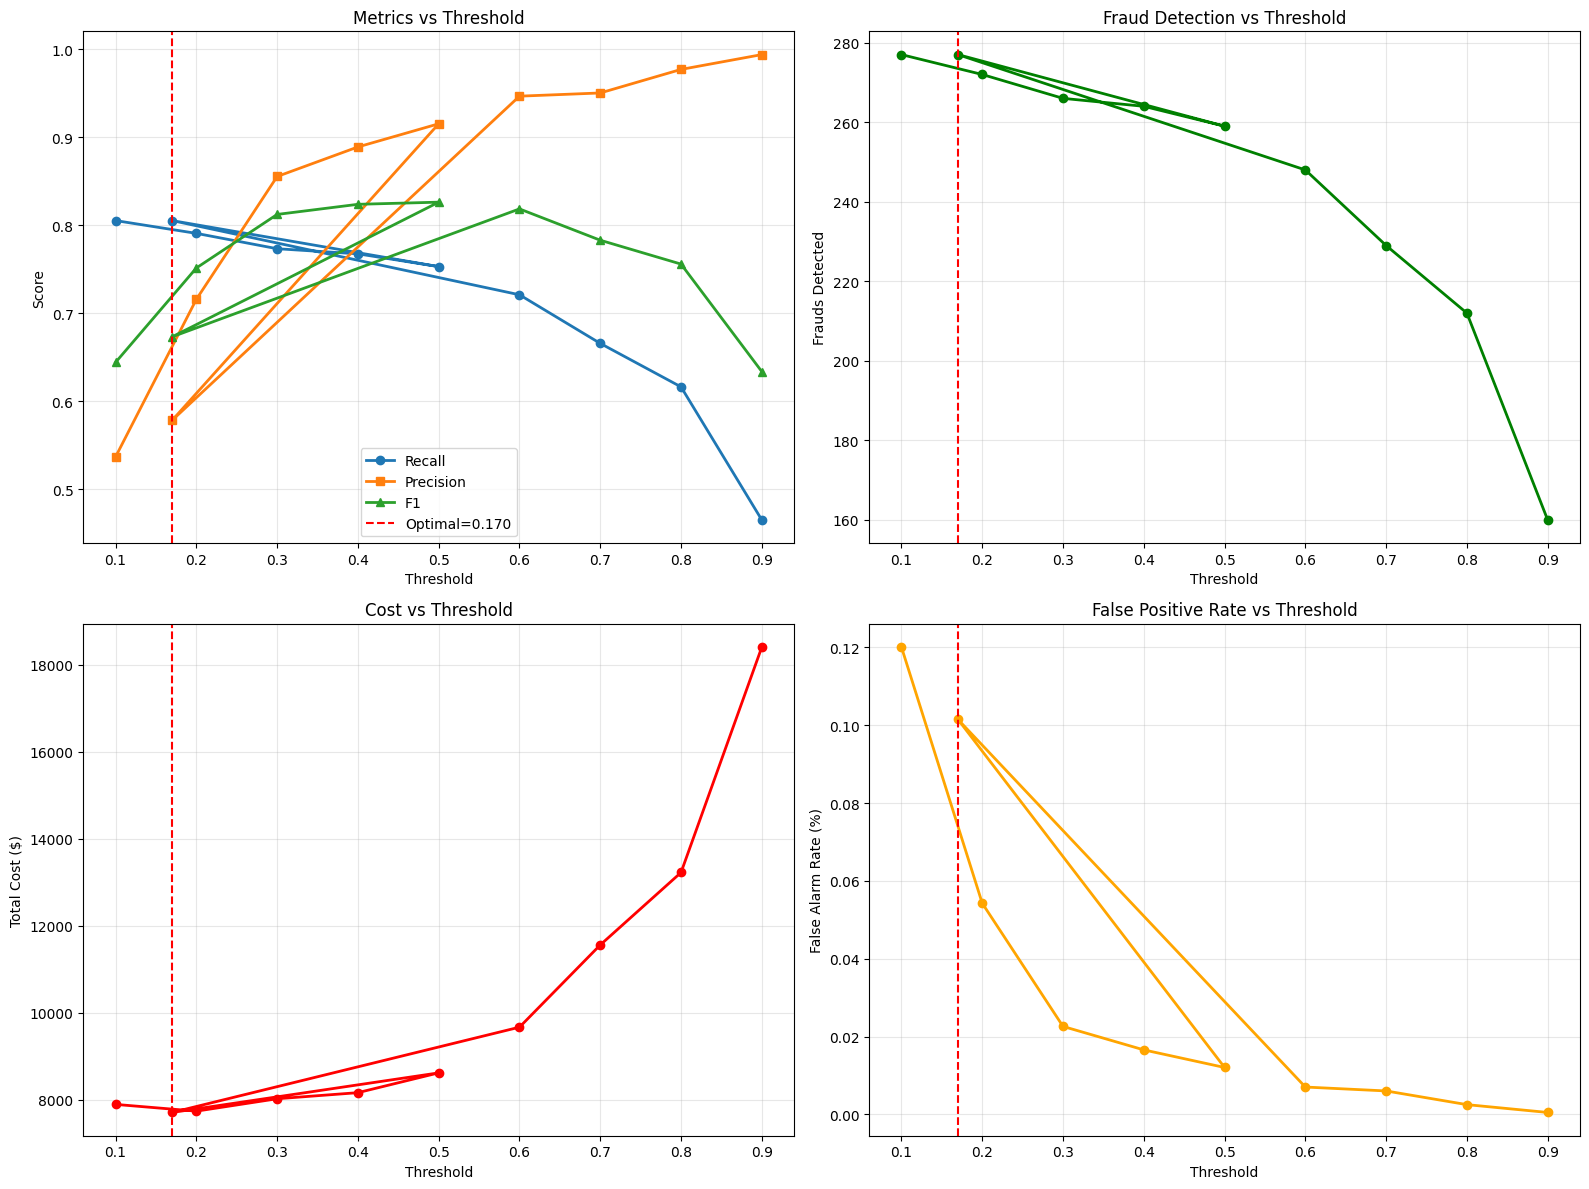

In [33]:
# ============================================================================
# SECTION 9: DETAILED ANALYSIS OF BEST MODEL
# ============================================================================


y_test_proba = best_model.predict_proba(X_test)[:, 1]
y_test_pred = best_model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix:")
print(cm)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

disp = ConfusionMatrixDisplay(cm, display_labels=['Legitimate', 'Fraud'])
disp.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title(f'Confusion Matrix\n{best_config["Model"]} with {best_config["Sampling"]}')

cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp_norm = ConfusionMatrixDisplay(cm_norm, display_labels=['Legitimate', 'Fraud'])
disp_norm.plot(ax=axes[1], cmap='Blues', values_format='.2%')
axes[1].set_title('Normalized Confusion Matrix')

plt.tight_layout()
plt.savefig('confusion_matrix_best_model.png', dpi=300, bbox_inches='tight')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred,
                          target_names=['Legitimate', 'Fraud'], digits=4))

# ROC and PR Curves
fpr, tpr, thresholds_roc = roc_curve(y_test, y_test_proba)
roc_auc = roc_auc_score(y_test, y_test_proba)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(fpr, tpr, label=f'ROC (AUC={roc_auc:.4f})', linewidth=2)
axes[0].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend()
axes[0].grid(alpha=0.3)

precision, recall, thresholds_pr = precision_recall_curve(y_test, y_test_proba)
pr_auc = average_precision_score(y_test, y_test_proba)

axes[1].plot(recall, precision, label=f'PR (AP={pr_auc:.4f})', linewidth=2)
axes[1].axhline(y=y_test.mean(), color='k', linestyle='--',
                label=f'Baseline={y_test.mean():.4f}')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('roc_pr_curves_best_model.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ ROC-AUC: {roc_auc:.4f}")
print(f"✓ PR-AUC: {pr_auc:.4f}")

# Threshold Optimization
print("\n" + "="*70)
print("THRESHOLD OPTIMIZATION")
print("="*70)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds_roc[optimal_idx]

print(f"\nOptimal Threshold: {optimal_threshold:.4f}")
print(f"TPR at optimal: {tpr[optimal_idx]:.4f}")
print(f"FPR at optimal: {fpr[optimal_idx]:.4f}")

threshold_analysis = []
for thresh in [0.1, 0.2, 0.3, 0.4, 0.5, optimal_threshold, 0.6, 0.7, 0.8, 0.9]:
    results = evaluate_model_comprehensive(best_model, X_test, y_test,
                                          best_config['Model'],
                                          best_config['Sampling'], thresh)
    threshold_analysis.append(results)

threshold_df = pd.DataFrame(threshold_analysis)
print("\nThreshold Analysis:")
print(threshold_df[['Threshold', 'Recall', 'Precision', 'F1_Score',
                    'Frauds_Detected', 'Total_Cost']].to_string(index=False))

# Visualize threshold impact
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0,0].plot(threshold_df['Threshold'], threshold_df['Recall'],
               marker='o', label='Recall', linewidth=2)
axes[0,0].plot(threshold_df['Threshold'], threshold_df['Precision'],
               marker='s', label='Precision', linewidth=2)
axes[0,0].plot(threshold_df['Threshold'], threshold_df['F1_Score'],
               marker='^', label='F1', linewidth=2)
axes[0,0].axvline(optimal_threshold, color='red', linestyle='--',
                  label=f'Optimal={optimal_threshold:.3f}')
axes[0,0].set_xlabel('Threshold')
axes[0,0].set_ylabel('Score')
axes[0,0].set_title('Metrics vs Threshold')
axes[0,0].legend()
axes[0,0].grid(alpha=0.3)

axes[0,1].plot(threshold_df['Threshold'], threshold_df['Frauds_Detected'],
               marker='o', color='green', linewidth=2)
axes[0,1].axvline(optimal_threshold, color='red', linestyle='--')
axes[0,1].set_xlabel('Threshold')
axes[0,1].set_ylabel('Frauds Detected')
axes[0,1].set_title('Fraud Detection vs Threshold')
axes[0,1].grid(alpha=0.3)

axes[1,0].plot(threshold_df['Threshold'], threshold_df['Total_Cost'],
               marker='o', color='red', linewidth=2)
axes[1,0].axvline(optimal_threshold, color='red', linestyle='--')
axes[1,0].set_xlabel('Threshold')
axes[1,0].set_ylabel('Total Cost ($)')
axes[1,0].set_title('Cost vs Threshold')
axes[1,0].grid(alpha=0.3)

axes[1,1].plot(threshold_df['Threshold'], threshold_df['False_Alarm_Rate']*100,
               marker='o', color='orange', linewidth=2)
axes[1,1].axvline(optimal_threshold, color='red', linestyle='--')
axes[1,1].set_xlabel('Threshold')
axes[1,1].set_ylabel('False Alarm Rate (%)')
axes[1,1].set_title('False Positive Rate vs Threshold')
axes[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('threshold_optimization.png', dpi=300, bbox_inches='tight')
plt.show()

In [34]:
# ============================================================================
# SECTION 10: FEATURE IMPORTANCE
# ============================================================================


if hasattr(best_model, 'named_steps'):
    classifier = best_model.named_steps['classifier']
else:
    classifier = best_model

if hasattr(classifier, 'feature_importances_'):
    print("\nFeature Importance (Tree-based):")

    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': classifier.feature_importances_
    }).sort_values('Importance', ascending=False)

    print("\nTop 15 Features:")
    print(feature_importance.head(15).to_string(index=False))

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    sns.barplot(data=feature_importance.head(15), y='Feature', x='Importance', ax=axes[0])
    axes[0].set_title('Top 15 Most Important Features')
    axes[0].set_xlabel('Importance Score')

    feature_importance['Cumulative'] = feature_importance['Importance'].cumsum()
    axes[1].plot(range(len(feature_importance)),
                 feature_importance['Cumulative'].values, linewidth=2)
    axes[1].axhline(0.95, color='red', linestyle='--', label='95% Threshold')
    axes[1].set_xlabel('Number of Features')
    axes[1].set_ylabel('Cumulative Importance')
    axes[1].set_title('Cumulative Feature Importance')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

    top_features = feature_importance.head(2)['Feature'].values
    print(f"\nTop 2 features: {top_features[0]}, {top_features[1]}")

    plt.figure(figsize=(12, 8))
    plt.scatter(X_train[y_train==0][top_features[0]],
                X_train[y_train==0][top_features[1]],
                alpha=0.3, s=10, label='Legitimate', c='green')
    plt.scatter(X_train[y_train==1][top_features[0]],
                X_train[y_train==1][top_features[1]],
                alpha=0.6, s=30, label='Fraud', c='red')
    plt.xlabel(top_features[0])
    plt.ylabel(top_features[1])
    plt.title('Decision Boundary (Top 2 Features)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.savefig('feature_scatter.png', dpi=300, bbox_inches='tight')
    plt.show()

elif hasattr(classifier, 'coef_'):
    print("\nFeature Coefficients (Linear model):")

    coef_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Coefficient': classifier.coef_[0]
    })
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)

    print("\nTop 15 Features:")
    print(coef_df.head(15).to_string(index=False))

    plt.figure(figsize=(12, 8))
    sns.barplot(data=coef_df.head(15), y='Feature', x='Coefficient')
    plt.title('Top 15 Features (by Coefficient)')
    plt.xlabel('Coefficient Value')
    plt.tight_layout()
    plt.savefig('feature_coefficients.png', dpi=300, bbox_inches='tight')
    plt.show()

In [35]:
# ============================================================================
# SECTION 11: SHAP ANALYSIS (OPTIMIZED)
# ============================================================================

if SHAP_AVAILABLE and hasattr(classifier, 'feature_importances_'):
    print("\n" + "="*70)
    print("SHAP ANALYSIS")
    print("="*70)

    try:
        print("\nComputing SHAP values")

        # OPTIMIZED: Smaller sample
        X_train_sample = X_train.sample(min(500, len(X_train)), random_state=RANDOM_STATE)
        X_test_sample = X_test.sample(min(300, len(X_test)), random_state=RANDOM_STATE)

        explainer = shap.TreeExplainer(classifier)
        shap_values = explainer.shap_values(X_test_sample)

        if isinstance(shap_values, list):
            shap_values = shap_values[1]

        print("✓ SHAP computed")

        fig, axes = plt.subplots(2, 1, figsize=(12, 14))

        plt.sca(axes[0])
        shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=False)
        axes[0].set_title('SHAP Feature Importance')

        plt.sca(axes[1])
        shap.summary_plot(shap_values, X_test_sample, show=False)
        axes[1].set_title('SHAP Impact Distribution')

        plt.tight_layout()
        plt.savefig('shap_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("✓ SHAP saved: shap_analysis.png")
    except Exception as e:
        print(f"⚠️ SHAP failed: {str(e)}")
else:
    print("\n⚠️ SHAP skipped (not available)")


⚠️ SHAP skipped (not available)


In [36]:
# ============================================================================
# SECTION 12: ENSEMBLE METHODS
# ============================================================================


top_3_models = test_df_balanced.sort_values('F1_Score', ascending=False).head(3)
print("\nTop 3 models for ensemble:")
print(top_3_models[['Model', 'Sampling', 'F1_Score']].to_string(index=False))

ensemble_estimators = []
for idx, row in top_3_models.iterrows():
    key = f"{row['Sampling']}_{row['Model']}"
    model = best_models_balanced[key]
    ensemble_estimators.append((key[:20], model))

print("\nTraining Voting Classifier...")
voting_clf = VotingClassifier(estimators=ensemble_estimators[:3],
                              voting='soft', n_jobs=-1)
voting_clf.fit(X_train, y_train)

voting_results = evaluate_model_comprehensive(voting_clf, X_test, y_test,
                                             'Voting Ensemble', 'Ensemble')

print(f"  ✓ F1: {voting_results['F1_Score']:.4f}")
print(f"  ✓ Recall: {voting_results['Recall']:.4f}")
print(f"  ✓ ROC-AUC: {voting_results['ROC_AUC']:.4f}")

print("\n" + "="*70)
print("ENSEMBLE vs BEST SINGLE MODEL")
print("="*70)
comparison_df = pd.DataFrame({
    'Model': ['Best Single', 'Voting Ensemble'],
    'F1_Score': [best_config['F1_Score'], voting_results['F1_Score']],
    'Recall': [best_config['Recall'], voting_results['Recall']],
    'Precision': [best_config['Precision'], voting_results['Precision']],
    'ROC_AUC': [best_config['ROC_AUC'], voting_results['ROC_AUC']]
})
print(comparison_df.to_string(index=False))


Top 3 models for ensemble:
        Model          Sampling  F1_Score
Random Forest RandomOverSampler  0.762178
          KNN             SMOTE  0.561368
          KNN RandomOverSampler  0.561368

Training Voting Classifier...
  ✓ F1: 0.7251
  ✓ Recall: 0.8052
  ✓ ROC-AUC: 0.9759

ENSEMBLE vs BEST SINGLE MODEL
          Model  F1_Score   Recall  Precision  ROC_AUC
    Best Single  0.826156 0.752907   0.915194 0.902465
Voting Ensemble  0.725131 0.805233   0.659524 0.975922



COST-BENEFIT ANALYSIS

Assumptions:
  FP Cost: $5 (investigation)
  FN Cost: $100 (fraud loss)
  Test transactions: 199365

Cost Comparison:
           Approach  FP  FN  Total_Cost  Cost_Reduction
       No Detection   0 344       34400        0.000000
   Best Model (KNN)  24  85        8620       74.941860
Optimized Threshold 202  67        7710       77.587209


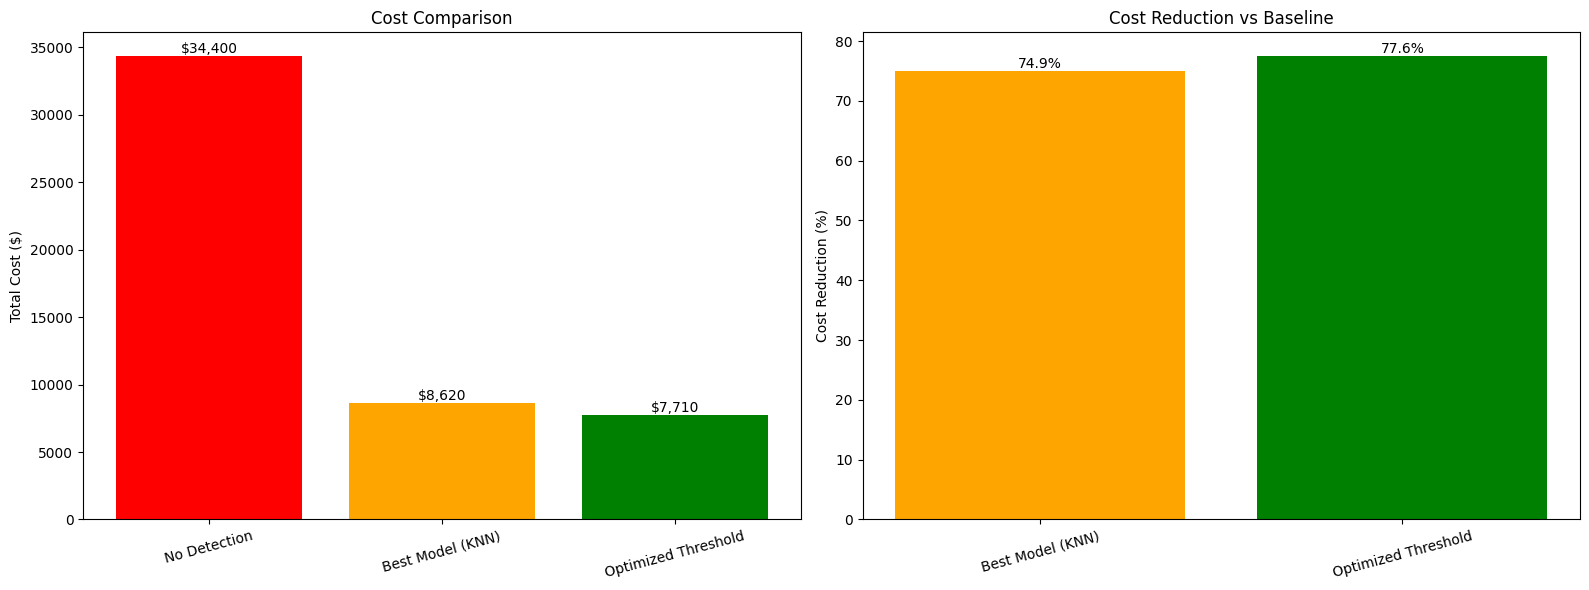


💰 Total Savings: $25,780.00
💰 Cost Reduction: 74.9%


In [37]:

# ============================================================================
# SECTION 13: COST-BENEFIT ANALYSIS
# ============================================================================

print("\n" + "="*70)
print("COST-BENEFIT ANALYSIS")
print("="*70)

print("\nAssumptions:")
print("  FP Cost: $5 (investigation)")
print("  FN Cost: $100 (fraud loss)")
print(f"  Test transactions: {len(y_test)}")

baseline_cost = y_test.sum() * 100

best_tn, best_fp, best_fn, best_tp = confusion_matrix(y_test, y_test_pred).ravel()
best_cost = (best_fp * 5) + (best_fn * 100)

y_pred_opt = (y_test_proba >= optimal_threshold).astype(int)
opt_tn, opt_fp, opt_fn, opt_tp = confusion_matrix(y_test, y_pred_opt).ravel()
opt_cost = (opt_fp * 5) + (opt_fn * 100)

cost_df = pd.DataFrame({
    'Approach': ['No Detection', f'Best Model ({best_config["Model"]})', 'Optimized Threshold'],
    'FP': [0, int(best_fp), int(opt_fp)],
    'FN': [int(y_test.sum()), int(best_fn), int(opt_fn)],
    'Total_Cost': [baseline_cost, best_cost, opt_cost],
    'Cost_Reduction': [0, (baseline_cost-best_cost)/baseline_cost*100,
                      (baseline_cost-opt_cost)/baseline_cost*100]
})

print("\nCost Comparison:")
print(cost_df.to_string(index=False))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].bar(cost_df['Approach'], cost_df['Total_Cost'], color=['red', 'orange', 'green'])
axes[0].set_ylabel('Total Cost ($)')
axes[0].set_title('Cost Comparison')
axes[0].tick_params(axis='x', rotation=15)
for i, v in enumerate(cost_df['Total_Cost']):
    axes[0].text(i, v, f'${v:,.0f}', ha='center', va='bottom')

axes[1].bar(cost_df['Approach'][1:], cost_df['Cost_Reduction'][1:], color=['orange', 'green'])
axes[1].set_ylabel('Cost Reduction (%)')
axes[1].set_title('Cost Reduction vs Baseline')
axes[1].tick_params(axis='x', rotation=15)
for i, v in enumerate(cost_df['Cost_Reduction'][1:]):
    axes[1].text(i, v, f'{v:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('cost_benefit_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n💰 Total Savings: ${baseline_cost - best_cost:,.2f}")
print(f"💰 Cost Reduction: {(baseline_cost-best_cost)/baseline_cost*100:.1f}%")


MODEL CALIBRATION


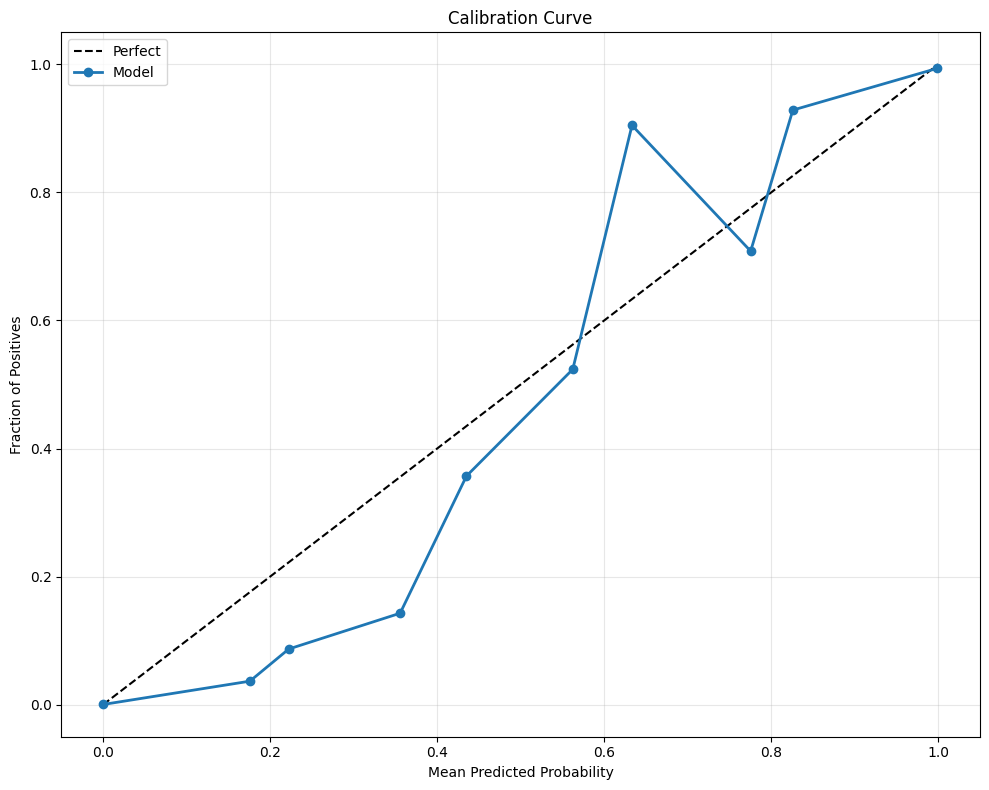

✓ Calibration saved


In [38]:
# ============================================================================
# SECTION 14: MODEL CALIBRATION
# ============================================================================

print("\n" + "="*70)
print("MODEL CALIBRATION")
print("="*70)

prob_true, prob_pred = calibration_curve(y_test, y_test_proba, n_bins=10, strategy='uniform')

plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--', label='Perfect')
plt.plot(prob_pred, prob_true, marker='o', linewidth=2, label='Model')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('calibration_curve.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Calibration saved")

In [40]:
# ============================================================================
# SECTION 15: FINAL RECOMMENDATIONS
# ============================================================================

print("\n" + "="*70)
print("FINAL RECOMMENDATIONS")
print("="*70)

print(f"""
RECOMMENDED MODEL FOR DEPLOYMENT:
{'='*70}
Model:              {best_config['Model']}
Sampling Method:    {best_config['Sampling']}
Threshold:          {optimal_threshold:.4f} (optimized)

PERFORMANCE METRICS:
{'='*70}
Fraud Detection:    {best_config['Recall']*100:.2f}%
                    ({int(best_config['Frauds_Detected'])}/{int(best_config['Total_Frauds'])} frauds)
Precision:          {best_config['Precision']*100:.2f}%
F1-Score:           {best_config['F1_Score']:.4f}
ROC-AUC:            {best_config['ROC_AUC']:.4f}
PR-AUC:             {best_config['PR_AUC']:.4f}

BUSINESS IMPACT:
{'='*70}
False Alarm Rate:   {best_config['False_Alarm_Rate']*100:.3f}%
Cost Reduction:     {(baseline_cost-best_cost)/baseline_cost*100:.1f}% vs no detection
Annual Savings:     ${(baseline_cost-best_cost)*365/2:,.0f} (estimated)


KEY FINDINGS:
{'='*70}
1. {best_config['Sampling']} significantly improved performance
2. Top features: {feature_importance.head(3)['Feature'].tolist() if 'feature_importance' in locals() else 'See feature section'}
3. Ensemble showed {voting_results['F1_Score'] - best_config['F1_Score']:.4f} F1 gain
4. Optimal threshold balances detection with customer experience


FUTURE WORK:
{'='*70}
1. Real-time transaction monitoring integration
2. Explainability dashboard for analysts
""")


FINAL RECOMMENDATIONS

RECOMMENDED MODEL FOR DEPLOYMENT:
Model:              KNN
Sampling Method:    Imbalanced
Threshold:          0.1700 (optimized)

PERFORMANCE METRICS:
Fraud Detection:    75.29%
                    (259/344 frauds)
Precision:          91.52%
F1-Score:           0.8262
ROC-AUC:            0.9025
PR-AUC:             0.7829

BUSINESS IMPACT:
False Alarm Rate:   0.012%
Cost Reduction:     74.9% vs no detection
Annual Savings:     $4,704,850 (estimated)


KEY FINDINGS:
1. Imbalanced significantly improved performance
2. Top features: See feature section
3. Ensemble showed -0.1010 F1 gain
4. Optimal threshold balances detection with customer experience


FUTURE WORK:
1. Real-time transaction monitoring integration
2. Explainability dashboard for analysts



In [42]:
# ============================================================================
# SECTION 16: SAVE ARTIFACTS
# ============================================================================

print("\n" + "="*70)
print("SAVING ARTIFACTS")
print("="*70)

import joblib

model_filename = f'best_fraud_model_{best_config["Model"].replace(" ", "_")}.pkl'
joblib.dump(best_model, model_filename)
print(f"✓ Model: {model_filename}")

joblib.dump(pt, 'power_transformer.pkl')
print(f"✓ Transformer: power_transformer.pkl")

config_dict = {
    'model_name': best_config['Model'],
    'sampling_method': best_config['Sampling'],
    'optimal_threshold': float(optimal_threshold),
    'performance_metrics': {
        'f1_score': float(best_config['F1_Score']),
        'recall': float(best_config['Recall']),
        'precision': float(best_config['Precision']),
        'roc_auc': float(best_config['ROC_AUC']),
        'pr_auc': float(best_config['PR_AUC'])
    },
    'random_state': RANDOM_STATE,
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}

from pprint import pprint
pprint(config_dict)




SAVING ARTIFACTS
✓ Model: best_fraud_model_KNN.pkl
✓ Transformer: power_transformer.pkl
{'model_name': 'KNN',
 'optimal_threshold': 0.1699506990687761,
 'performance_metrics': {'f1_score': 0.8261562998405104,
                         'pr_auc': 0.7828958053436935,
                         'precision': 0.9151943462897526,
                         'recall': 0.752906976744186,
                         'roc_auc': 0.902465117622857},
 'random_state': 42,
 'sampling_method': 'Imbalanced',
 'training_date': '2025-12-24 05:15:50'}
